In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def read_points_from_file(filename):
    """
    Reads points from a file. Each line in the file should contain two numbers (x and y coordinates).
    Returns a list of tuples representing points.
    """
    points = []
    with open(filename, 'r') as file:
        for line in file:
            x, y = map(float, line.strip().split())
            points.append((x, y))
    return points

In [3]:
filename = 'path/to/points.txt'  
points = np.array(read_points_from_file(filename))
print(points)

[[0.5 1.5]
 [0.5 0.5]
 [1.  0.5]
 [0.  1. ]
 [0.  0. ]]


In [4]:
def lexigraphic_sort(points):
    points_sorted = sorted(points, key=lambda k: [k[0], k[1]])
    return points_sorted

In [5]:

def partition_into_3s(points):
    number_of_points = len(points)
    if number_of_points < 4:
        raise ValueError("Point set size needs to be 4 or greater.")
    partitioned_list = []
    for index in range(0, number_of_points, 3):
        if index + 4 >= number_of_points:
            if number_of_points % 3 == 1:
                partitioned_list.append(points[index:index+2])
                partitioned_list.append(points[index+2:index+4])
                return partitioned_list
            elif number_of_points % 3 == 2:
                partitioned_list.append(points[index:index+2])
                return partitioned_list
        else:
            partitioned_list.append(points[index:index+3])
    return partitioned_list

In [6]:
class Edges():
    def __init__(self):
        self.edges = []
        self.num_edges = 0
        self.inner = None
        self.outer = None

    def push_back(self, new_edge):
        self.edges.append(new_edge)
        self.num_edges += 1

    def set_extreme_edges(self, left_most_edge, right_most_edge):
        self.inner = left_most_edge
        self.outer = right_most_edge

    def __str__(self):
        return f'EDGES | Edges: {[str(edge) for edge in self.edges]}, Num_edges: {self.num_edges}, Inner: {self.inner}, Outer: {self.outer} |'

    def onext(self, edge):
        return self.edges[edge].onext

    def oprev(self, edge):
        return self.edges[edge].oprev

    def set_onext(self, dest_edge, source_edge):
        self.edges[dest_edge].onext = source_edge

    def set_oprev(self, dest_edge, source_edge):
        self.edges[dest_edge].oprev = source_edge

    def dest(self, edge):
        return self.edges[edge].dest

    def set_dest(self, dest_edge, source_edge):
        self.edges[dest_edge].dest = source_edge

    def org(self, edge):
        return self.edges[edge].org

    def set_org(self, dest_edge, source_edge):
        self.edges[dest_edge].org = source_edge

    def sym(self, edge):
        return self.edges[edge].sym

    def set_sym(self, dest_edge, source_edge):
        self.edges[dest_edge].sym = source_edge

    def set_lprev(self, dest_edge, source_edge):
        self.edges[self.edges[dest_edge].onext].sym = source_edge

    def lprev(self, edge):
        return self.edges[self.edges[edge].onext].sym

    def set_rprev(self, dest_edge, source_edge):
        self.edges[self.edges[dest_edge].sym].onext = source_edge

    def rprev(self, edge):
        return self.edges[self.edges[edge].sym].onext

    def set_lnext(self, dest_edge, source_edge):
        self.edges[self.edges[dest_edge].sym].oprev = source_edge

    def lnext(self, edge):
        return self.edges[self.edges[edge].sym].oprev

    def set_rnext(self, dest_edge, source_edge):
        self.edges[self.edges[dest_edge].oprev].sym = source_edge

    def rnext(self, edge):
        return self.edges[self.edges[edge].oprev].sym

    def splice(self, edge1, edge2):
        """
        This function is used when adding another edge to a point in the
        triangulation which has existing edges connected to it. The next and
        previous ccw edges are updated accordingly for each of the input edges.

        Parameters
        ----------
        edge1 : Edge class
        edge2 : Edge class
        """
        self.set_oprev(self.onext(edge1), edge2)
        self.set_oprev(self.onext(edge2), edge1)

        edge_1_holder = self.onext(edge1)
        edge_2_holder = self.onext(edge2)

        self.set_onext(edge1, edge_2_holder)
        self.set_onext(edge2, edge_1_holder)

    def connect(self, edge1, edge2):
        """
        This function takes two seperated edges and creates a new edge
        connecting the two.

        Parameters
        ----------
        edge1 : Edge class
        edge2 : Edge class

        Returns
        -------
        out : int
            index of the created edge
        """

        last_index = self.num_edges
        edge, edge_sym = setup_edge(self.dest(edge1), self.org(edge2), last_index)

        self.push_back(edge)
        self.push_back(edge_sym)

        edge1_sym_oprev = self.oprev(self.sym(edge1))
        new_edge_index = edge.index

        self.splice(new_edge_index, edge1_sym_oprev)
        self.splice(self.sym(new_edge_index), edge2)

        return new_edge_index

    def kill_edge(self, e):
        """
        This function removes an edge from the triangulation by setting the
        status of edge.deactivate to True. The function also fixed the
        connecting edges too.

        Parameters
        ----------
        e : Edge class
            edge to remove from the triangulation
        """
        # Fix the local triangulation
        self.splice(e, self.edges[e].oprev)
        self.splice(self.edges[e].sym, self.edges[self.edges[e].sym].oprev)

        # Set the status of the edge and it's symetric edge to kill
        self.edges[e].deactivate = True
        self.edges[self.edges[e].sym].deactivate = True

In [7]:
class Edge():
    """
    This class represents a single edge as defined in the Guibas and Stolfi
    edge algebra formalism.

    Attributes
    ----------
    index : int
        unique edge index
    org : int
        index of edge origin point
    dest : int
        index of edge destination point
    sym : int
        index of symetric edge
    onext : int
        index of next ccw edge connected to the origin point
    oprev : int
        index of previous ccw edge connected to the origin point
    deactivate : bool
        status of edge in triangulation. False if the edge is still part of
        the triangulation.
    """
    def __init__(self, idx, org, dst, s, onxt, oprv):
        self.index = idx
        self.org = org
        self.dest = dst
        self.sym = s
        self.onext = onxt
        self.oprev = oprv
        self.deactivate = False

    def __str__(self):
        return (
                f"EDGE| Index: {self.index}, Org: {self.org}, "
                f"Dest: {self.dest}, Sym: {self.sym}, "
                f"Onext: {self.onext}, Oprev: {self.oprev}, "
                f"Deactivate: {self.deactivate} |"
                )

    def shift_indices(self, shift_edges, shift_points):
        """
        This function is used to shift the indices of an edge. This is used
        when merging sets of edges to ensure each edge has a unique index.

        Parameters
        ----------
        shift_edges : int
            integer to shift edge indices by
        shift_points : int
            integer to shift orgin and destination points by
        """
        self.index += shift_edges
        self.org += shift_points
        self.dest += shift_points
        self.sym += shift_edges
        self.onext += shift_edges
        self.oprev += shift_edges

In [8]:
def setup_edge(origin, dest, edge_idx):
    """
    This function takes in the index of two points and creates an edge array,
    as well as an edge for the symetric edge.

    Parameters
    ----------
    origin : int
        index of origin point
    dest : int
        index of destination point
    edge_idx : int
        The index of the new edge

    Returns
    -------
    edge : Edge class
        Edge connecting org to dest
    edge_sym : Edge class
        Edge connecting dest to org
    """
    e1_idx = edge_idx
    e2_idx = edge_idx + 1

    edge = Edge(e1_idx, origin, dest, e2_idx, e1_idx, e1_idx)
    edge_sym = Edge(e2_idx, dest, origin, e1_idx, e2_idx, e2_idx)

    return edge, edge_sym

In [9]:
class TriangulationEdges(Edges):
    def __init__(self, points_subset):
        super().__init__()
        self.points = points_subset
        if len(points_subset) == 2:
            p1, p2 = 0, 1
            edge, edge_sym = setup_edge(p1, p2, 0)
            self.push_back(edge)
            self.push_back(edge_sym)

            left_most_edge = edge.index
            right_most_edge = self.edges[edge.index].sym

            self.set_extreme_edges(left_most_edge, right_most_edge)
            return
        elif len(points_subset) == 3:
            p1, p2, p3 = 0, 1, 2
            # Create the first two edges of the triangle
            edge1, edge1_sym = setup_edge(p1, p2, 0)
            self.push_back(edge1)
            self.push_back(edge1_sym)

            edge2, edge2_sym = setup_edge(p2, p3, 2)
            self.push_back(edge2)
            self.push_back(edge2_sym)

            self.splice(edge1_sym.index, edge2.index)

            pt1 = points_subset[self.edges[edge1.index].org]
            pt2 = points_subset[self.edges[edge1.index].dest]
            pt3 = points_subset[p3]

            if is_right_turn(pt1, pt2, pt3):
                # Points are in CCW orientiaton
                c = self.connect(edge2.index, edge1.index)
                self.set_extreme_edges(edge1.index, edge2_sym.index)
                return

            if is_left_turn(pt1, pt2, pt3):
                # Points are in CW orientiaton
                c = self.connect(edge2.index, edge1.index)
                self.set_extreme_edges(self.edges[c].sym, c)
                return

            # Points are collinear
            self.set_extreme_edges(edge1.index, edge2_sym.index)
        else:
            raise ValueError("Initializing subset of size 3 not supported")

    def __str__(self):
        return f"TEDGES | {self.points}, " + super().__str__()

    def get_min_x(self):
        return min(self.points, key = lambda t: t[0])[0]

    def get_max_x(self):
        return max(self.points, key = lambda t: t[0])[0]

    def get_min_y(self):
        return min(self.points, key = lambda t: t[1])[1]

    def get_max_y(self):
        return max(self.points, key = lambda t: t[1])[1]


    def shift_indices(self, shift_edges, shift_points):
        for edge in self.edges:
            edge.shift_indices(shift_edges, shift_points)

    def combine_data(self, appendage_triangulation):
        # Calculate the capacity of the new edges array
        base_triangulation_num_edges = self.num_edges
        base_triangulation_num_points = len(self.points)
        appendage_triangulation_num_edges = appendage_triangulation.num_edges

        appendage_triangulation.shift_indices(base_triangulation_num_edges, base_triangulation_num_points)

        self.edges.extend(appendage_triangulation.edges)
        self.num_edges += appendage_triangulation_num_edges
        self.points.extend(appendage_triangulation.points)

        return self

In [10]:
def is_right_turn(p, q, r):
    if len(p) != 2 or len(q) != 2 or len(r) != 2 :
        raise ValueError("Not enough coords for an input")

    px, py = p
    qx, qy = q
    rx, ry = r

    checker_array = np.array(
        [[1, px, py],
        [1, qx, qy],
        [1, rx, ry]]
    )

    return np.linalg.det(checker_array) > 0

def is_left_turn(p, q, r):
    if len(p) != 2 or len(q) != 2 or len(r) != 2 :
        raise ValueError("Not enough coords for an input")

    px, py = p
    qx, qy = q
    rx, ry = r

    checker_array = np.array(
        [[1, px, py],
        [1, qx, qy],
        [1, rx, ry]]
    )

    return np.linalg.det(checker_array) < 0

def in_circle(a, b, c, d):

    result = np.array([
        [a[0], a[1], a[0]**2+a[1]**2, 1],
        [b[0], b[1], b[0]**2+b[1]**2, 1],
        [c[0], c[1], c[0]**2+c[1]**2, 1],
        [d[0], d[1], d[0]**2+d[1]**2, 1]
    ])

    return np.linalg.det(result) >= 0


In [11]:
def lowest_common_tangent(left_hull, right_hull):
    left_hull_outer_edge = left_hull.outer
    right_hull_inner_edge = right_hull.inner

    left_reference_edge_origin = left_hull.points[left_hull.org(left_hull_outer_edge)]
    left_reference_edge_dest = left_hull.points[left_hull.dest(left_hull_outer_edge)]

    right_reference_edge_origin = right_hull.points[right_hull.org(right_hull_inner_edge)]
    right_reference_edge_dest = right_hull.points[right_hull.dest(right_hull_inner_edge)]

    is_right_incorrect = is_left_turn(right_reference_edge_origin, right_reference_edge_dest, left_hull.points[left_hull.edges[left_hull_outer_edge].org])
    is_left_incorrect = is_right_turn(left_reference_edge_origin, left_reference_edge_dest, right_hull.points[right_hull.edges[right_hull_inner_edge].org])
    while is_left_incorrect or is_right_incorrect:
        if is_right_incorrect:
            right_hull_inner_edge = right_hull.lnext(right_hull_inner_edge)
            right_reference_edge_origin = right_hull.points[right_hull.org(right_hull_inner_edge)]
            right_reference_edge_dest = right_hull.points[right_hull.dest(right_hull_inner_edge)]
        elif is_left_incorrect:
            left_hull_outer_edge = left_hull.rprev(left_hull_outer_edge)
            left_reference_edge_origin = left_hull.points[left_hull.org(left_hull_outer_edge)]
            left_reference_edge_dest = left_hull.points[left_hull.dest(left_hull_outer_edge)]
        is_right_incorrect = is_left_turn(right_reference_edge_origin, right_reference_edge_dest, left_hull.points[left_hull.org(left_hull_outer_edge)])
        is_left_incorrect = is_right_turn(left_reference_edge_origin, left_reference_edge_dest, right_hull.points[right_hull.org(right_hull_inner_edge)])
    return left_hull_outer_edge, right_hull_inner_edge


In [12]:
def connect_triangulations(combined_edges, handle_indices):
    ldi = handle_indices['left_inner']
    rdi = handle_indices['right_inner']
    ldo = handle_indices['left_outer']
    rdo = handle_indices['right_outer']
    base = combined_edges.connect(combined_edges.sym(ldi), rdi)
    if np.array_equal(combined_edges.points[combined_edges.org(ldi)], combined_edges.points[combined_edges.org(ldo)]):
        ldo = base
    if np.array_equal(combined_edges.points[combined_edges.org(rdi)], combined_edges.points[combined_edges.org(rdo)]):
        rdo = combined_edges.sym(base)
    combined_edges.set_extreme_edges(ldo, rdo)
    return base

In [13]:
def generalized_candidate_finder(hull, candidate, reference_point_1, reference_point_2, left=True):
    if left:
        candidate_neighbor = hull.oprev(candidate)
    else:
        candidate_neighbor = hull.onext(candidate)

    candidate_neighbor_dest = hull.dest(candidate_neighbor)
    candidate_dest = hull.dest(candidate)
    is_ccw = is_right_turn(reference_point_1, reference_point_2, hull.points[candidate_neighbor_dest])
    next_candidate_valid = in_circle(reference_point_2, reference_point_1, hull.points[candidate_dest], hull.points[candidate_neighbor_dest])
    while is_ccw and not next_candidate_valid:

        if left:
            next_candidate = hull.oprev(candidate)
        else:
            next_candidate = hull.onext(candidate)

        hull.kill_edge(candidate)
        candidate = next_candidate

        if left:
            next_candidate = hull.oprev(candidate)
        else:
            next_candidate = hull.onext(candidate)

        candidate_neighbor_dest = hull.dest(next_candidate)
        candidate_dest = hull.dest(candidate)
        is_ccw = is_right_turn(reference_point_1, reference_point_2, hull.points[candidate_neighbor_dest])
        next_candidate_valid = in_circle(reference_point_2, reference_point_1, hull.points[candidate_dest], hull.points[candidate_neighbor_dest])

    return hull, candidate

In [14]:
def find_correct_edge(triangulation, left_candidate, right_candidate, left_candidate_valid):
    a = triangulation.points[triangulation.edges[right_candidate].dest]
    b = triangulation.points[triangulation.edges[right_candidate].org]
    c = triangulation.points[triangulation.edges[left_candidate].org]
    deciding_point = triangulation.points[triangulation.dest(left_candidate)]
    result = not in_circle(a, b, c, deciding_point) and left_candidate_valid
    return result

In [15]:
def weave_hulls(triangulation, base):
    base_origin = triangulation.points[triangulation.org(base)]
    base_dest = triangulation.points[triangulation.dest(base)]

    right_candidate = triangulation.rprev(base)
    right_candidate_dest = triangulation.points[triangulation.dest(right_candidate)]
    is_right_candidate_correct = is_right_turn(base_origin, base_dest, right_candidate_dest)

    left_candidate = triangulation.oprev(base)
    left_candidate_dest = triangulation.points[triangulation.dest(left_candidate)]
    is_left_candidate_correct = is_right_turn(base_origin, base_dest, left_candidate_dest)

    are_either_candidate_incorrect = True
    while are_either_candidate_incorrect:
        if not is_right_candidate_correct and not is_left_candidate_correct:
            break

        if is_right_candidate_correct:
            triangulation, right_candidate = generalized_candidate_finder(triangulation, right_candidate, base_origin, base_dest, left=False)

        if is_left_candidate_correct:
            triangulation, left_candidate = generalized_candidate_finder(triangulation, left_candidate, base_origin, base_dest, left=True)

        left_candidate_strong_valid = find_correct_edge(triangulation, left_candidate, right_candidate, is_left_candidate_correct)

        if not is_right_candidate_correct or left_candidate_strong_valid:
            base = triangulation.connect(left_candidate, triangulation.sym(base))
        else:
            base = triangulation.connect(triangulation.sym(base), triangulation.sym(right_candidate))

        base_origin = triangulation.points[triangulation.org(base)]
        base_dest = triangulation.points[triangulation.dest(base)]

        right_candidate = triangulation.rprev(base)
        right_candidate_dest = triangulation.points[triangulation.dest(right_candidate)]
        is_right_candidate_correct = is_right_turn(base_origin, base_dest, right_candidate_dest)

        left_candidate = triangulation.oprev(base)
        left_candidate_dest = triangulation.points[triangulation.dest(left_candidate)]
        is_left_candidate_correct = is_right_turn(base_origin, base_dest, left_candidate_dest)

        if not is_right_candidate_correct and not is_left_candidate_correct:
            are_either_candidate_incorrect = False

    return triangulation


In [16]:
def combine_triangulations(hull_left, hull_right, ldi, rdi):
    handle_indices = {
        'left_outer': hull_left.inner,
        'right_outer': hull_right.outer + hull_left.num_edges,
        'right_inner': rdi + hull_left.num_edges,
        'left_inner': ldi
    }
    combined_triangulation = hull_left.combine_data(hull_right)
    base_point_index = connect_triangulations(combined_triangulation, handle_indices)
    new_triangulation = weave_hulls(combined_triangulation, base_point_index)
    return new_triangulation


In [17]:
def merge_triangulations(triangulations):
    if len(triangulations) == 1:
        return triangulations
    elif len(triangulations) == 2:
        ldi, rdi = lowest_common_tangent(triangulations[0], triangulations[1])
        d_triang = combine_triangulations(triangulations[0], triangulations[1], ldi, rdi)
        return d_triang
    else:
        new_triangulations = []
        number_of_triangulations = len(triangulations)
        for index in range(0, number_of_triangulations, 2):
            if (number_of_triangulations - index) == 1:
                new_triangulations.append(triangulations[index])
            else:
                new_triangulation = merge_triangulations(triangulations[index:index+2])
                new_triangulations.append(new_triangulation)
        return merge_triangulations(new_triangulations)

In [18]:
def plot_triangulation(triangulation):
    x_coords = []
    y_coords = []
    for edge in triangulation.edges:
        if not edge.deactivate:
            index_1 = edge.org
            index_2 = edge.dest
            coord_1, coord_2 = (triangulation.points[index_1], triangulation.points[index_2])
            x_coords.append([coord_1[0], coord_2[0]])
            y_coords.append([coord_1[1], coord_2[1]])
    for x_coord, y_coord in zip(x_coords, y_coords):
        plt.plot(x_coord, y_coord)
        plt.axis([0, 10, 0, 10])

In [19]:
def triangulate(positions):
    sorted_positions = lexigraphic_sort(positions)
    split_positions = partition_into_3s(sorted_positions)
    groups = [TriangulationEdges(points_subset) for points_subset in split_positions]
    groups = merge_triangulations(groups)
    return groups


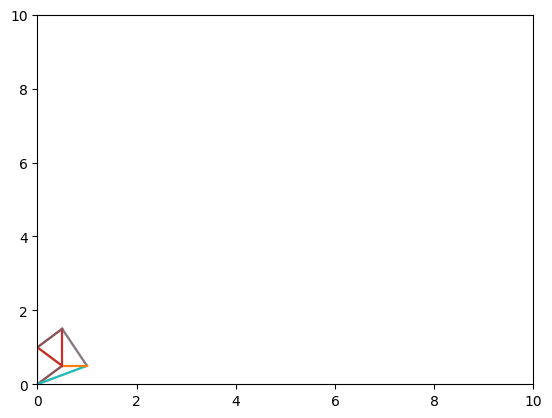

In [20]:
triangulation = triangulate(points)
plot_triangulation(triangulation)